# Differentiation in Python: Symbolic, Numerical and Automatic

<a name='1'></a>
## 1 - Introduction to Symbolic Computation with `SymPy`

In [26]:
import math

math.sqrt(18)

4.242640687119285

In [27]:
# This format of module import allows to use the sympy functions without sympy. prefix.
from sympy import *

# This is actually sympy.sqrt function, but sympy. prefix is omitted.
sqrt(18)

3*sqrt(2)

In [28]:
N(sqrt(18), 8)

4.2426407

In [29]:
# List of symbols.
x, y = symbols('x y')
# Definition of the expression.
expr = 2 * x**2 - x * y
expr

2*x**2 - x*y

In [30]:
expr_manip = x * (expr + x * y + x**3)
expr_manip

x*(x**3 + 2*x**2)

In [31]:
expand(expr_manip)

x**4 + 2*x**3

Or factorise it:

In [32]:
factor(expr_manip)

x**3*(x + 2)

To substitute particular values for the variables in the expression, you can use the following code:

In [33]:
expr.evalf(subs={x: -1, y: 2})

4.00000000000000

In [34]:
f_symb = x ** 2
f_symb.evalf(subs={x: 3})

9.00000000000000

### evaluate for an array

In [35]:
import numpy as np
x_array = np.array([1, 2, 3])
try:
    f_symb(x_array)
except TypeError as err:
    print(err)

'Pow' object is not callable


It is possible to evaluate the symbolic functions for each element of the array, but you need to make a function `NumPy`-friendly first:

In [36]:
from sympy.utilities.lambdify import lambdify

f_symb_numpy = lambdify(x, f_symb, 'numpy')

The following code should work now:

In [38]:
print("x: \n", x_array)
print("f(x) = x**2: \n", f_symb_numpy(x_array))

x: 
 [1 2 3]
f(x) = x**2: 
 [1 4 9]


### Symbolic Differentiation with `SymPy`


In [ ]:
diff(x**3, x)

3*x**2

In [ ]:
dfdx_composed = diff(exp(-2*x) + 3*sin(3*x), x)
dfdx_composed

9*cos(3*x) - 2*exp(-2*x)

## 2-Numerical Differentiation


### Numerical Differentiation with `NumPy`

In [42]:
def f(x):
    return x**2

In [43]:
x_array_2 = np.linspace(-5, 5, 100)
dfdx_numerical = np.gradient(f(x_array_2), x_array_2)

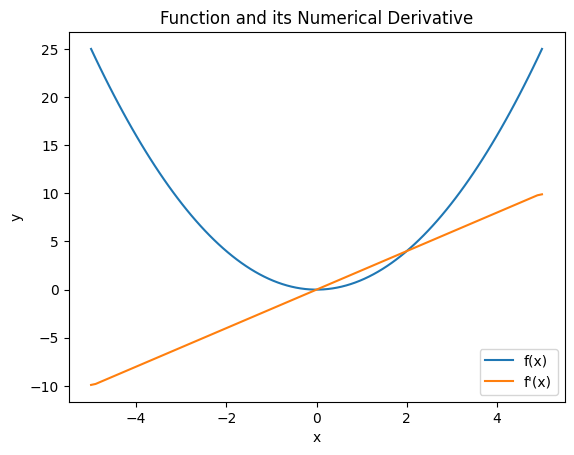

In [44]:
import matplotlib.pyplot as plt
plt.plot(x_array_2, f(x_array_2), label='f(x)')
plt.plot(x_array_2, dfdx_numerical, label="f'(x)")
plt.title("Function and its Numerical Derivative")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

<a name='4'></a>
## 3 - Automatic Differentiation

**Automatic differentiation** (autodiff) method breaks down the function into common functions ($sin$, $cos$, $log$, power functions, etc.), and constructs the computational graph consisting of the basic functions. Then the chain rule is used to compute the derivative at any node of the graph. It is the most commonly used approach in machine learning applications and neural networks, as the computational graph for the function and its derivatives can be built during the construction of the neural network, saving in future computations.

The main disadvantage of it is implementational difficulty. However, nowadays there are libraries that are convenient to use, such as [MyGrad](https://mygrad.readthedocs.io/en/latest/index.html), [Autograd](https://autograd.readthedocs.io/en/latest/) and [JAX](https://jax.readthedocs.io/en/latest/). `Autograd` and `JAX` are the most commonly used in the frameworks to build neural networks. `JAX` brings together `Autograd` functionality for optimization problems, and `XLA` (Accelerated Linear Algebra) compiler for parallel computing.

The syntax of `Autograd` and `JAX` are slightly different. It would be overwhelming to cover both at this stage. In this notebook you will be performing automatic differentiation using one of them: `JAX`.

<a name='3.1'></a>
### 3.1 - Introduction to `JAX`

To begin with, load the required libraries. From `jax` package you need to load just a couple of functions for now (`grad` and `vmap`). Package `jax.numpy` is a wrapped `NumPy`, which pretty much replaces `NumPy` when `JAX` is used. It can be loaded as `np` as if it was an original `NumPy` in most of the cases. However, in this notebook you'll upload it as `jnp` to distinguish them for now.

In [2]:
import numpy as np

x_array = np.array([1, 2, 3])

In [1]:
from jax import grad, vmap
import jax.numpy as jnp

In [3]:
x_array_jnp = jnp.array([1.0, 2.0, 3.0])

print("Type of NumPy array:", type(x_array))
print("Type of JAX NumPy array:", type(x_array_jnp))

Type of NumPy array: <class 'numpy.ndarray'>
Type of JAX NumPy array: <class 'jaxlib._jax.ArrayImpl'>


The same array can be created just converting previously defined `x_array = np.array([1, 2, 3])`, although in some cases `JAX` does not operate with integers, thus the values need to be converted to floats. You will see an example of it below.

In [4]:
x_array_jnp = jnp.array(x_array.astype('float32'))
print("JAX NumPy array:", x_array_jnp)
print("Type of JAX NumPy array:", type(x_array_jnp))

JAX NumPy array: [1. 2. 3.]
Type of JAX NumPy array: <class 'jaxlib._jax.ArrayImpl'>


But sometimes working with `jnp` arrays the approach needs to be changed. In the following code, trying to assign a new value to one of the elements, you will get an error:

In [5]:
try:
    x_array_jnp[2] = 4.0
except TypeError as err:
    print(err)

JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html


To assign a new value to an element in the `jnp` array you need to apply functions `.at[i]`, stating which element to update, and `.set(value)` to set a new value. These functions also operate **out-of-place**, the updated array is returned as a new array and the original array is not modified by the update.

In [6]:
y_array_jnp = x_array_jnp.at[2].set(4.0)
print(y_array_jnp)

[1. 2. 4.]


 <a name='3.2'></a>
### 3.2 - Automatic Differentiation with `JAX` 

Time to do automatic differentiation with `JAX`. The following code will calculate the derivative of the previously defined function $f\left(x\right) = x^2$ at the point $x = 3$:

In [8]:
def f(x):
    return x**2

In [ ]:
print("Function value at x = 3:", f(3.0))
print("Derivative value at x = 3:", grad(f)(3.0))  # jax.grad

Function value at x = 3: 9.0
Derivative value at x = 3: 6.0


Very easy, right? Keep in mind, please, that this cannot be done using integers. The following code will output an error:

In [10]:
try:
    grad(f)(3)
except TypeError as err:
    print(err)

grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.


Try to apply the `grad` function to an array, calculating the derivative for each of its elements: 

In [ ]:
try:
    grad(f)(x_array_jnp)
except TypeError as err:
    print(err)

Gradient only defined for scalar-output functions. Output had shape: (3,).


In [11]:
dfdx_jax_vmap = vmap(grad(f))(x_array_jnp)
print(dfdx_jax_vmap)

[2. 4. 6.]


The results are pretty much the same, but the time used is different. Numerical approach is obviously inefficient when differentiation needs to be performed many times, which happens a lot training machine learning models. Symbolic and automatic approach seem to be performing similarly for this simple example. But if the function becomes a little bit more complicated, symbolic computation will experiance significant expression swell and the calculations will slow down.

*Note*: Sometimes the execution time results may vary slightly, especially for automatic differentiation. You can run the code above a few time to see different outputs. That does not influence the conclusion that numerical differentiation is slower. `timeit` module can be used more efficiently to evaluate execution time of the codes, but that would unnecessary overcomplicate the codes here.

Try to define some polynomial function, which should not be that hard to differentiate, and compare the computation time for its differentiation symbolically and automatically: